<a href="https://colab.research.google.com/github/omidmno2/stockMarketPrediction_DL/blob/main/AAPL_15m_CNN_LSTM_with_standard_scaler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 6.2 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=7786382a66e6e2b19d035aa71633789719860893d5e4b214c20f61fea119cb36
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [4]:
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

In [18]:
import yfinance as yf
fifteen_m_data = yf.download(tickers='AAPL', period = '60d', interval = '15m')
fifteen_m_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-08-02 09:30:00-04:00,146.360001,146.949997,145.270004,145.399994,145.399994,8494835
2021-08-02 09:45:00-04:00,145.500000,146.009995,145.369995,145.949997,145.949997,4055907
2021-08-02 10:00:00-04:00,145.903000,146.240005,145.600006,146.060104,146.060104,3518727
2021-08-02 10:15:00-04:00,146.059998,146.250000,145.600006,145.910004,145.910004,2567609
2021-08-02 10:30:00-04:00,145.910004,145.990005,145.410004,145.539993,145.539993,2267311
...,...,...,...,...,...,...
2021-10-25 10:30:00-04:00,147.910004,148.080002,147.740097,147.850006,147.850006,1619209
2021-10-25 10:45:00-04:00,147.850006,148.080002,147.779999,148.078705,148.078705,1246181
2021-10-25 11:00:00-04:00,148.074997,148.289993,147.830002,148.235001,148.235001,1444939


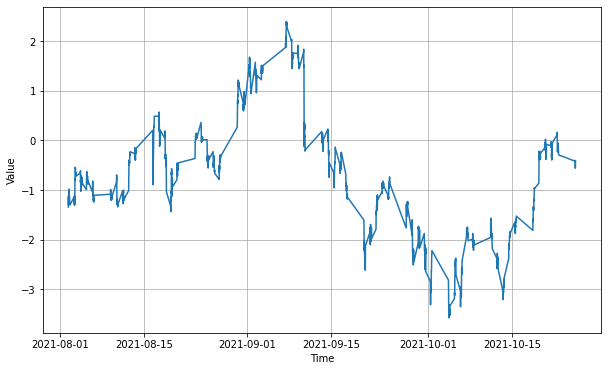

In [19]:
from sklearn.preprocessing import StandardScaler

series = fifteen_m_data['Close'].values.reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

series = np.array(series)
time = np.array(fifteen_m_data.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [20]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [21]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [22]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [23]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(1000,)
Epoch 1/100
4/4 [==============================] - 4s 66ms/step - loss: 3.1629 - mae: 3.6160
Epoch 2/100
4/4 [==============================] - 0s 39ms/step - loss: 3.1423 - mae: 3.5959
Epoch 3/100
4/4 [==============================] - 0s 41ms/step - loss: 3.1055 - mae: 3.5598
Epoch 4/100
4/4 [==============================] - 0s 40ms/step - loss: 3.0546 - mae: 3.5099
Epoch 5/100
4/4 [==============================] - 0s 40ms/step - loss: 2.9937 - mae: 3.4503
Epoch 6/100
4/4 [==============================] - 0s 40ms/step - loss: 2.9220 - mae: 3.3796
Epoch 7/100
4/4 [==============================] - 0s 39ms/step - loss: 2.8423 - mae: 3.3010
Epoch 8/100
4/4 [==============================] - 0s 40ms/step - loss: 2.7543 - mae: 3.2144
Epoch 9/100
4/4 [==============================] - 0s 42ms/step - loss: 2.6565 - mae: 3.1179
Epoch 10/100
4/4 [==============================] - 0s 41ms/s

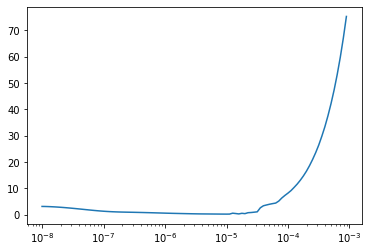

In [24]:
plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-8, 1e-4, 0, 60])

In [25]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=2e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
10/10 [==============================] - 4s 36ms/step - loss: 1.1687 - mae: 1.5996
Epoch 2/150
10/10 [==============================] - 1s 36ms/step - loss: 0.5133 - mae: 0.8791
Epoch 3/150
10/10 [==============================] - 1s 35ms/step - loss: 0.3470 - mae: 0.7066
Epoch 4/150
10/10 [==============================] - 1s 35ms/step - loss: 0.1781 - mae: 0.4754
Epoch 5/150
10/10 [==============================] - 1s 34ms/step - loss: 0.2677 - mae: 0.6243
Epoch 6/150
10/10 [==============================] - 1s 35ms/step - loss: 0.1536 - mae: 0.4419
Epoch 7/150
10/10 [==============================] - 1s 34ms/step - loss: 0.1903 - mae: 0.5072
Epoch 8/150
10/10 [==============================] - 1s 35ms/step - loss: 0.2334 - mae: 0.5826
Epoch 9/150
10/10 [==============================] - 1s 35ms/step - loss: 0.1576 - mae: 0.4540
Epoch 10/150
10/10 [==============================] - 1s 35ms/step - loss: 0.2638 - mae: 0.6258
Epoch 11/150
10/10 [=============================

In [26]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

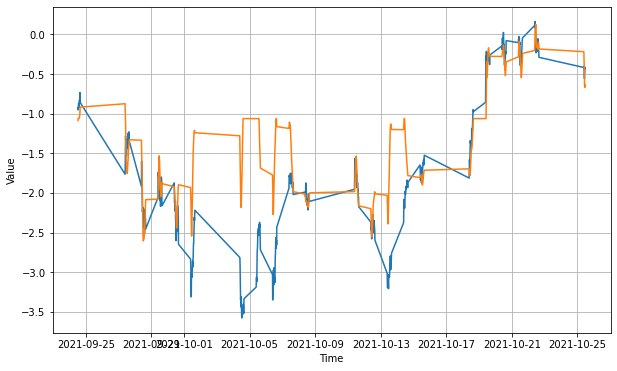

In [27]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [85]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

2.9076653

In [86]:
print(rnn_forecast)

# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[ 1.8615248   1.7424954   1.6254276   1.5828438   1.5096529   1.2573298
  1.0262463   1.0331986   0.9170458   0.85491836  0.80024785  0.74824077
  0.8002536   0.89955854  0.9167741   0.95568514  0.98705095  1.0694323
  1.0905286   1.0947118   1.0764086   1.0222079   0.9827543   1.014646
  1.0832359   1.1294173   1.2006402   1.2447231   1.2763056   1.3129449
  1.3696734   1.4225957   1.4376614   1.451085    1.3964739   1.3505807
  1.3507994   1.333136    1.3088098   1.297214    1.3350991   1.4011832
  1.4018337   1.3683496   1.343937    1.3724538   1.4264511   1.472338
  1.4976425   1.5262094   1.5580019   1.5960584   1.7178046   1.8205835
  1.8426906   1.9088467   1.9203616   1.9193264   1.9374311   1.9852957
  2.096164    2.16221     2.1217124   2.0119026   1.9000998   1.8937011
  1.944038    2.0328455   2.0425076   2.028165    2.0922403   2.127544
  2.1277385   2.0989702   2.0168924   1.9688941   1.9599887   1.8887556
  1.8464599   1.8512491   1.880507    1.9644139   2.0015728   2.03